In [2]:
import pandas as pd

import pickle as pkl

from sklearn.linear_model import Lasso, LassoCV, LogisticRegressionCV, LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, KFold, cross_val_predict
from sklearn.metrics import r2_score, explained_variance_score, normalized_mutual_info_score, \
    mutual_info_score, mean_absolute_error, make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest

from skll.metrics import spearman, pearson 


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 6,6

Custom model implementations and functions are stored in `src/dairyml.py`

In [25]:
from dairyml import PerfectClassifierMeanRegressor, plot_r2, BoundedLasso, BoundedLassoPlusLogReg, plot_coefficients, DummyRegressorCustom

## Import the Data
Load the data from the pickle files created in `preproccess.ipynb`

In [3]:
with open("../pkl/data/data_outliers_removed", "rb" ) as f:
    [X, Y] = pkl.load(f)

## Modelling with Lasso

Define a splitter- this produces the data splits used for cross-validation. `random_state` is defined for repeatability. 

In [7]:
splitter= KFold(n_splits=10,shuffle=True,random_state=7)

Choose statistics used to evaluate the models

In [8]:
scoring = {'r2':make_scorer(r2_score), 
           'SRC':make_scorer(spearman), 
           'PCC':make_scorer(pearson), 
           'MI':make_scorer(mutual_info_score), 
           'MAE':make_scorer(mean_absolute_error)}

In [17]:
try:
    overall_results = pd.read_csv('../reports/model_results.csv',index_col=0)
except FileNotFoundError:
    overall_results = pd.DataFrame(columns = scoring.keys())

### Lasso

- Conduct a grid search on the regularization parameter alpha on a log scale between 1e-3 and 1 (np.logspace takes exponents of 10 as arguments)
- For each value of alpha in this range, we perform 10-fold cross validation (CV) on the training data
- Choose the best model based on R^2 score in CV using the `refit` argument of `GridSearchCV`

In [19]:
param_grid = {'alpha': np.logspace(-3, 0, 50)}

refit = 'r2'

search = GridSearchCV(estimator=Lasso(),param_grid=param_grid,scoring=scoring,refit=refit,cv=splitter)
search.fit(X,Y)

GridSearchCV(cv=KFold(n_splits=10, random_state=7, shuffle=True),
       error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([0.001  , 0.00115, 0.00133, 0.00153, 0.00176, 0.00202, 0.00233,
       0.00268, 0.00309, 0.00356, 0.00409, 0.00471, 0.00543, 0.00625,
       0.0072 , 0.00829, 0.00954, 0.01099, 0.01265, 0.01456, 0.01677,
       0.01931, 0.02223, 0.0256 , 0.02947, 0.03393, 0.03907, 0.04498,...18, 0.32375,
       0.37276, 0.42919, 0.49417, 0.56899, 0.65513, 0.75431, 0.86851,
       1.     ])},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score='warn',
       scoring={'r2': make_scorer(r2_score), 'SRC': make_scorer(spearman), 'PCC': make_scorer(pearson), 'MI': make_scorer(mutual_info_score), 'MAE': make

#### Best value of alpha for Lasso
Print the best value of the regularization parameter, as chosen by 10-fold CV R^2 score above

In [20]:
search.best_estimator_.alpha

0.03906939937054617

#### Lasso test performance
Highest R^2 score for the Lasso model from 10-fold CV (this is the performance we can expect on the test set)

In [21]:
search.cv_results_['mean_test_r2'][np.argmax(search.cv_results_['mean_test_'+refit])]

0.4476823274646198

In [22]:
for score_name in scoring.keys():
    overall_results.loc['Lasso',score_name] = np.round(search.cv_results_['mean_test_'+score_name][np.argmax(search.cv_results_['mean_test_'+refit])],2)
overall_results

,r2,SRC,PCC,MI,MAE
Dummy Mean,-0.02,0.00,-0.00,-0.00,1.94
Dummy Median All,-0.32,0.00,-0.00,-0.00,1.68
Dummy Median Nonzero,-0.08,0.00,-0.00,-0.00,1.77
"Perfect Clasif., Mean Regr.",0.13,0.73,0.41,0.53,1.53
Lasso,0.45,0.61,0.70,3.07,1.23


### Bounded Lasso
This attempts to fix an obvious issue with the above predictor, that the model predicts negative lactose content for some foods. BoundedLasso wraps sklearn's Lasso model, and "clips" the model output so that negative output values become 0. 

In [31]:
param_grid = {'alpha': np.logspace(-3, 0, 100)}

refit = 'r2'

search = GridSearchCV(estimator=BoundedLasso(),param_grid=param_grid,scoring=scoring,refit=refit,cv=splitter)
search.fit(X,Y)

GridSearchCV(cv=KFold(n_splits=10, random_state=7, shuffle=True),
       error_score='raise-deprecating', estimator=BoundedLasso(alpha=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([0.001  , 0.00107, ..., 0.9326 , 1.     ])},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score='warn',
       scoring={'r2': make_scorer(r2_score), 'SRC': make_scorer(spearman), 'PCC': make_scorer(pearson), 'MI': make_scorer(mutual_info_score), 'MAE': make_scorer(mean_absolute_error)},
       verbose=0)

#### Best value of alpha for Bounded Lasso
Print the best value of the regularization parameter, as chosen by 10-fold CV R^2 score above

In [32]:
search.best_estimator_.alpha

0.02009233002565047

#### Bounded Lasso test results

In [33]:
for score_name in scoring.keys():
    overall_results.loc['Bounded Lasso',score_name] = np.round(search.cv_results_['mean_test_'+score_name][np.argmax(search.cv_results_['mean_test_'+refit])],2)
overall_results

,r2,SRC,PCC,MI,MAE
Dummy Mean,-0.02,0.00,-0.00,-0.00,1.94
Dummy Median All,-0.32,0.00,-0.00,-0.00,1.68
Dummy Median Nonzero,-0.08,0.00,-0.00,-0.00,1.77
"Perfect Clasif., Mean Regr.",0.13,0.73,0.41,0.53,1.53
Lasso,0.45,0.61,0.70,3.07,1.23
Bounded Lasso,0.55,0.64,0.75,2.87,1.08


#### Feature importances
Here we plot the non-zero coefficients of the Bounded Lasso model. The magnitude of the coefficient for each feature indicates how much each feature contributes to the overall lactose estimate. We can see that choline, sugar, and potassium contribute positively to the lactose estimate, while fiber, cholesterol, and protein contribute negatively. 

In [34]:
# plot_coefficients(search.best_estimator_,X)

### Bounded Lasso plus Classifier
- Add a binary classifier to the model to predict whether a food is zero or non-zero lactose. 
- In the case that the classifier predicts 0 lactose, the overall model output is 0. 
- In the case that the classifier predicts non-zero, the output from the bounded lasso model is used

#### Evaluate the classifier by itself

In [35]:
Y_binary = Y != 0

param_grid_LR = {'C': np.logspace(-4, 4, 30)}

search_LR = GridSearchCV(estimator=LogisticRegression(solver='lbfgs',max_iter=2000),param_grid=param_grid_LR,scoring=('accuracy','recall'),refit='accuracy',cv=10)
search_LR.fit(X,Y_binary)

# param_grid_SVC = {'C': np.logspace(-4, 4, 30)}
# search_SVC = GridSearchCV(estimator=SVC(kernel='rbf'),param_grid=param_grid_SVC,scoring=('accuracy','recall'),refit='accuracy',cv=10)
# search_SVC.fit(X,Y_binary)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e-04, 1.88739e-04, 3.56225e-04, 6.72336e-04, 1.26896e-03,
       2.39503e-03, 4.52035e-03, 8.53168e-03, 1.61026e-02, 3.03920e-02,
       5.73615e-02, 1.08264e-01, 2.04336e-01, 3.85662e-01, 7.27895e-01,
       1.37382e+00, 2.59294e+00, 4.89390e+00, 9.23671e+00, 1.74333e+01,
       3.29034e+01, 6.21017e+01, 1.17210e+02, 2.21222e+02, 4.17532e+02,
       7.88046e+02, 1.48735e+03, 2.80722e+03, 5.29832e+03, 1.00000e+04])},
       pre_dispatch='2*n_jobs', refit='accuracy',
       return_train_score='warn', scoring=('accuracy', 'recall'),
       verbose=0)

#### Classifier accuracy
The classifier achieves 89% accuracy in predicting 0 vs non-zero lactose.

In [36]:
search_LR.best_score_

0.8873994638069705

### Evaluate the Bounded Lasso + Classifier Model

adjusted C grid below to give slightly more resolution around the chosen value from previous run

In [51]:
param_grid = {'alpha': np.logspace(-3, -1, 10), 'C': np.logspace(4, 6, 10)}
refit='r2'
search = GridSearchCV(estimator=BoundedLassoPlusLogReg(),param_grid=param_grid,scoring=scoring,refit=refit,cv=splitter)
search.fit(X,Y)

GridSearchCV(cv=KFold(n_splits=10, random_state=7, shuffle=True),
       error_score='raise-deprecating',
       estimator=BoundedLassoPlusLogReg(C=None, alpha=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([0.001  , 0.00167, 0.00278, 0.00464, 0.00774, 0.01292, 0.02154,
       0.03594, 0.05995, 0.1    ]), 'C': array([  10000.     ,   16681.00537,   27825.59402,   46415.88834,
         77426.36827,  129154.9665 ,  215443.469  ,  359381.36638,
        599484.25032, 1000000.     ])},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score='warn',
       scoring={'r2': make_scorer(r2_score), 'SRC': make_scorer(spearman), 'PCC': make_scorer(pearson), 'MI': make_scorer(mutual_info_score), 'MAE': make_scorer(mean_absolute_error)},
       verbose=0)

#### Plot actual vs predicted results

In [52]:
y_pred = cross_val_predict(search.best_estimator_,X,Y,cv=splitter)

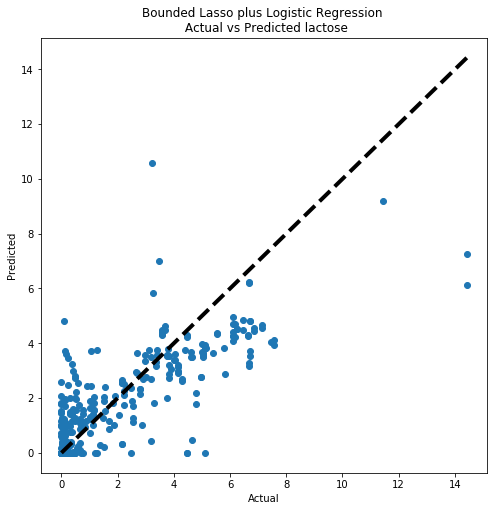

In [53]:
fig, ax = plt.subplots(figsize=[8,8])
ax.scatter(Y, y_pred)
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Bounded Lasso plus Logistic Regression \n Actual vs Predicted lactose')
plt.show()

In [54]:
search.best_estimator_.get_params()

{'C': 215443.46900318822, 'alpha': 0.021544346900318832}

#### Model test performance

In [55]:
for score_name in scoring.keys():
    overall_results.loc['Bounded Lasso + LogReg',score_name] = np.round(search.cv_results_['mean_test_'+score_name][np.argmax(search.cv_results_['mean_test_'+refit])],2)
overall_results

,r2,SRC,PCC,MI,MAE
Dummy Mean,-0.02,0.00,-0.00,-0.00,1.94
Dummy Median All,-0.32,0.00,-0.00,-0.00,1.68
Dummy Median Nonzero,-0.08,0.00,-0.00,-0.00,1.77
"Perfect Clasif., Mean Regr.",0.13,0.73,0.41,0.53,1.53
Lasso,0.45,0.61,0.70,3.07,1.23
Bounded Lasso,0.55,0.64,0.75,2.87,1.08
Bounded Lasso + LogReg,0.64,0.80,0.82,2.66,0.86


In [56]:
overall_results.to_csv('../reports/model_results.csv')